In [1]:
import pandas as pd

# CSV-Datei einlesen
telefonkunden = pd.read_csv('telefonkunden.csv')

# Die ersten paar Zeilen der Datei anzeigen
print(telefonkunden.head())

   region  tenure  age  marital  address  income  ed  employ  retire  gender  \
0       2      13   44        1        9    64.0   4       5     0.0       0   
1       3      11   33        1        7   136.0   5       5     0.0       0   
2       3      68   52        1       24   116.0   1      29     0.0       1   
3       2      33   33        0       12    33.0   2       0     0.0       1   
4       2      23   30        1        9    30.0   1       2     0.0       0   

   reside  custcat  
0       2        1  
1       6        4  
2       2        3  
3       1        1  
4       4        3  


In [2]:
# Anzahl der Kategorien und Einträge in jeder Kategorie
category_counts = telefonkunden['custcat'].value_counts()

# Ausgabe der Anzahl der Kategorien und Einträge
print("Anzahl der Kategorien:", len(category_counts))
print("Anzahl der Einträge in jeder Kategorie:")
print(category_counts)

Anzahl der Kategorien: 4
Anzahl der Einträge in jeder Kategorie:
custcat
3    281
1    266
4    236
2    217
Name: count, dtype: int64


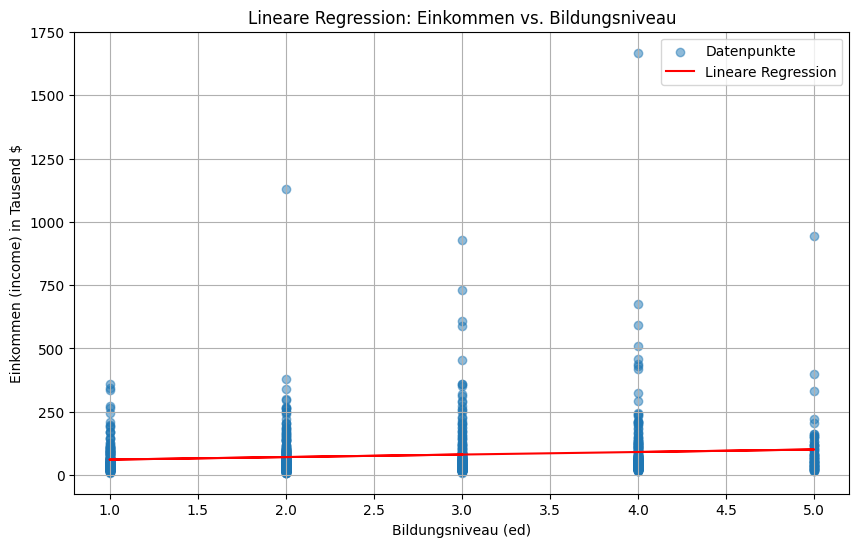

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Scatterplot der Datenpunkte
# Lineare Regression
X = telefonkunden[['ed']].values.reshape(-1, 1)
y = telefonkunden['income'].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
y_pred = linear_regressor.predict(X)

# Plot der linearen Regression
plt.figure(figsize=(10, 6))
plt.scatter(telefonkunden['ed'], telefonkunden['income'], alpha=0.5, label='Datenpunkte')
plt.plot(telefonkunden['ed'], y_pred, color='red', label='Lineare Regression')
plt.title('Lineare Regression: Einkommen vs. Bildungsniveau')
plt.xlabel('Bildungsniveau (ed)')
plt.ylabel('Einkommen (income) in Tausend $')
plt.legend()
plt.grid(True)
plt.show()


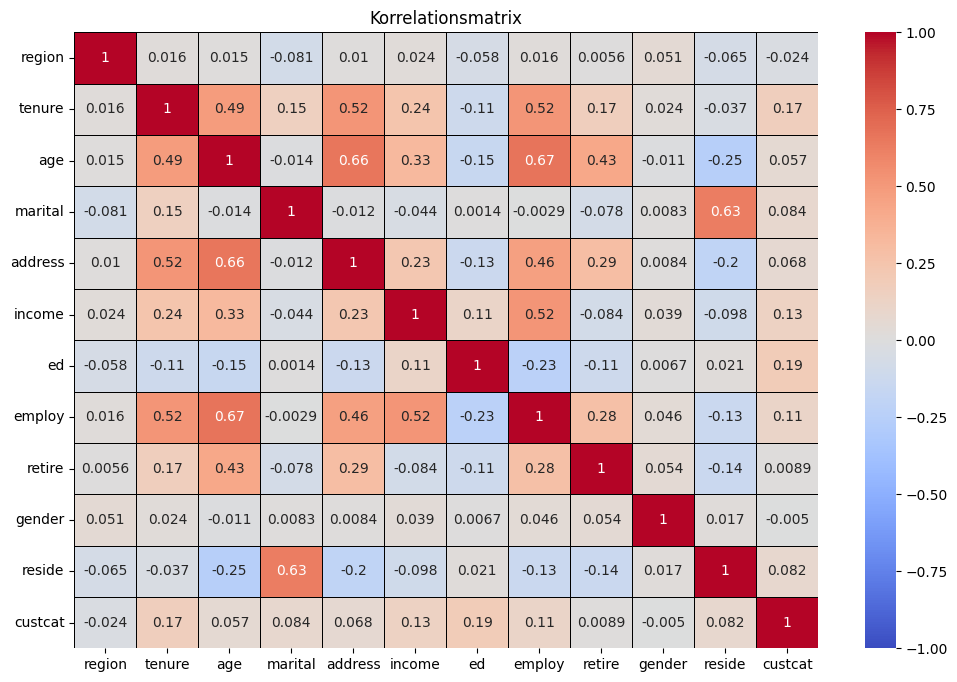

In [4]:
# Korrelationsmatrix
corr = telefonkunden.corr()
plt.figure(figsize=(12, 8))  # Größe der Figur anpassen
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Korrelationsmatrix')
plt.show()

In [5]:
# Median berechnen und zur Tabelle hinzufügen
median = telefonkunden.median()
describe_df = telefonkunden.describe()
describe_df.loc['median'] = median
describe_df


,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000,2.331000,2.487000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961,1.435793,1.120306
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000,3.000000,3.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000,8.000000,4.000000
median,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Grundlegende Übersicht
print("Gender-Verteilung:")
print(telefonkunden['gender'].value_counts())

# Vergleich von Einkommen nach Gender
print("\nDurchschnittliches Einkommen nach Gender:")
print(telefonkunden.groupby('gender')['income'].mean())

Gender-Verteilung:
gender
1    517
0    483
Name: count, dtype: int64

Durchschnittliches Einkommen nach Gender:
gender
0    73.250518
1    81.537718
Name: income, dtype: float64


Durchschnittliches Einkommen nach Kundengruppe:
custcat
1    54.759398
2    74.834101
3    89.032028
4    92.000000
Name: income, dtype: float64


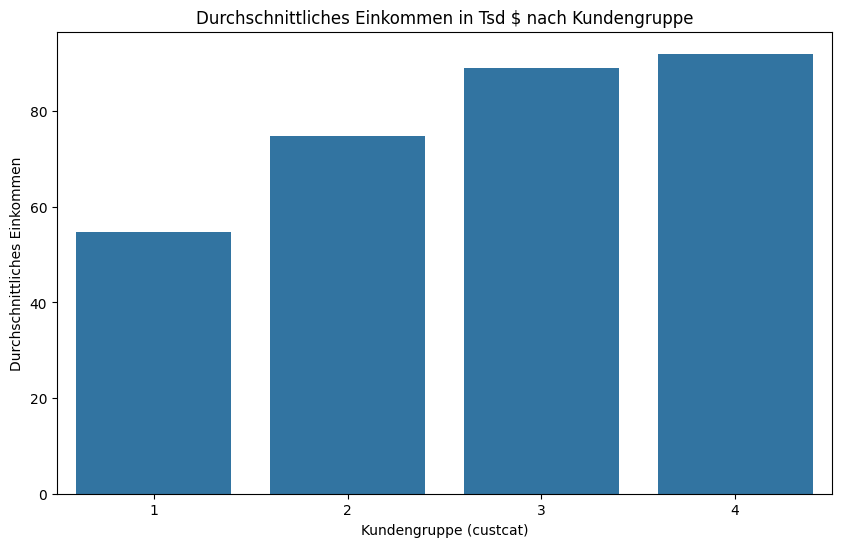

Durchschnittliche Zugehörigkeitsdauer nach Kundengruppe:
custcat
1    24.676692
2    43.345622
3    40.078292
4    35.144068
Name: tenure, dtype: float64


In [7]:
# Durchschnittliches Einkommen nach Kundengruppe (custcat) berechnen
avg_income_by_custcat = telefonkunden.groupby('custcat')['income'].mean()

# Ergebnis anzeigen
print("Durchschnittliches Einkommen nach Kundengruppe:")
print(avg_income_by_custcat)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_income_by_custcat.index, y=avg_income_by_custcat.values)
plt.title('Durchschnittliches Einkommen in Tsd $ nach Kundengruppe')
plt.xlabel('Kundengruppe (custcat)')
plt.ylabel('Durchschnittliches Einkommen')
plt.show()

# Durchschnittliche Zugehörigkeitsdauer (tenure) nach Kundengruppe berechnen
avg_tenure_by_custcat = telefonkunden.groupby('custcat')['tenure'].mean()

# Ergebnis anzeigen
print("Durchschnittliche Zugehörigkeitsdauer nach Kundengruppe:")
print(avg_tenure_by_custcat)

In [8]:
# Durchschnittswerte der Merkmale je Servicekategorie berechnen
avg_features_by_custcat = telefonkunden.groupby('custcat').mean()

# Ausgabe in einer Tabelle
avg_features_by_custcat

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside
custcat,,,,,,,,,,,
1,2.090226,24.676692,39.657895,0.417293,9.390977,54.759398,2.364662,8.484962,0.041353,0.507519,2.199248
2,1.963134,43.345622,41.788018,0.529954,12.571429,74.834101,2.958525,10.576037,0.032258,0.548387,2.336406
3,1.996441,40.078292,44.430605,0.494662,13.380783,89.032028,2.153025,14.309609,0.078292,0.505338,2.227758
4,2.029661,35.144068,40.601695,0.550847,10.868644,92.000000,3.368644,10.228814,0.029661,0.512712,2.597458


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden.drop('custcat', axis=1)
Y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# f_classif wird verwendet, um die ANOVA F-Statistik zwischen den Feauture und der Zielvariable zu berechnen. Diese Statistik misst die Abhängigkeit zwischen den Feauture und der Zielvariable
k_best = SelectKBest(score_func=f_classif, k='all')
#fit berechnet die Scores für jedes Feature basierend auf den Trainingsdaten (X_training) und der Zielvariable (Y_training).
k_best.fit(X_training, Y_training)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': k_best.scores_})
print("Feature Scores using SelectKBest:")
print(feature_scores.sort_values(by='Score', ascending=False))


# Feature-Selection: Recursive Feature Elimination (RFE)
# Ein RandomForestClassifier-Modell wird erstellt
model = RandomForestClassifier(random_state=1)
# RFE-Objekt wird erstellt, um die besten 5 Features auszuwählen
rfe = RFE(model, n_features_to_select=5)
# RFE wird auf die Trainingsdaten angewendet, um die besten Features zu ermitteln
rfe.fit(X_training, Y_training)
# Die Rankings der Features werden in einem DataFrame gespeichert
rfe_features = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
print("Feature Rankings using RFE:")
print(rfe_features.sort_values(by='Ranking'))

# Modelltraining und -bewertung mit den besten Features
selected_features = feature_scores.sort_values(by='Score', ascending=False)['Feature'].head(5).tolist()
X_train_selected = X_training[selected_features]
X_test_selected = X_test[selected_features]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_selected, Y_training)
Y_pred = knn.predict(X_test_selected)

print("Klassifikationsbericht mit ausgewählten Features:")
print(classification_report(Y_test, Y_pred))

Feature Scores using SelectKBest:
    Feature      Score
6        ed  53.817180
1    tenure  29.390559
7    employ  15.678875
4   address  10.281757
2       age   8.576518
5    income   5.774136
10   reside   4.634765
3   marital   2.695598
0    region   2.283164
8    retire   1.872375
9    gender   0.219995
Feature Rankings using RFE:
    Feature  Ranking
1    tenure        1
2       age        1
5    income        1
4   address        1
7    employ        1
6        ed        2
10   reside        3
0    region        4
9    gender        5
3   marital        6
8    retire        7
Klassifikationsbericht mit ausgewählten Features:
              precision    recall  f1-score   support

           1       0.36      0.45      0.40        53
           2       0.33      0.41      0.37        44
           3       0.29      0.29      0.29        56
           4       0.16      0.09      0.11        47

    accuracy                           0.31       200
   macro avg       0.29      0.31 

0.395


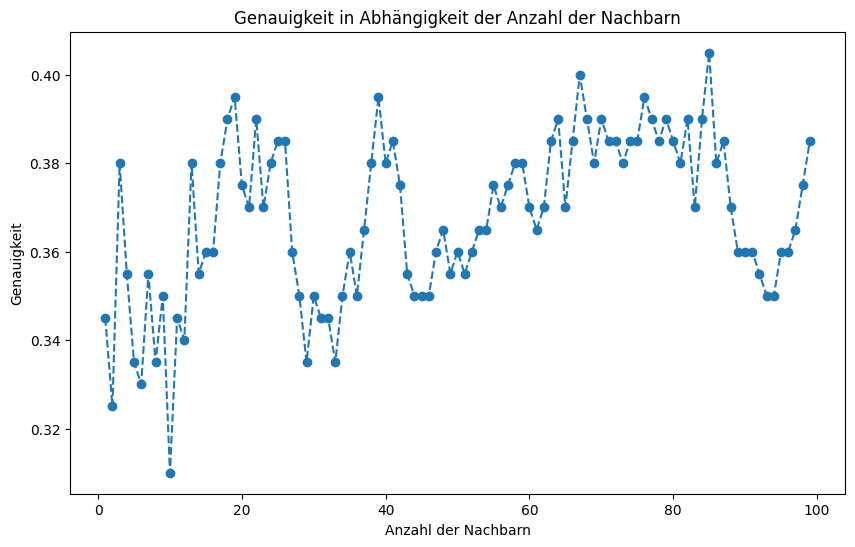

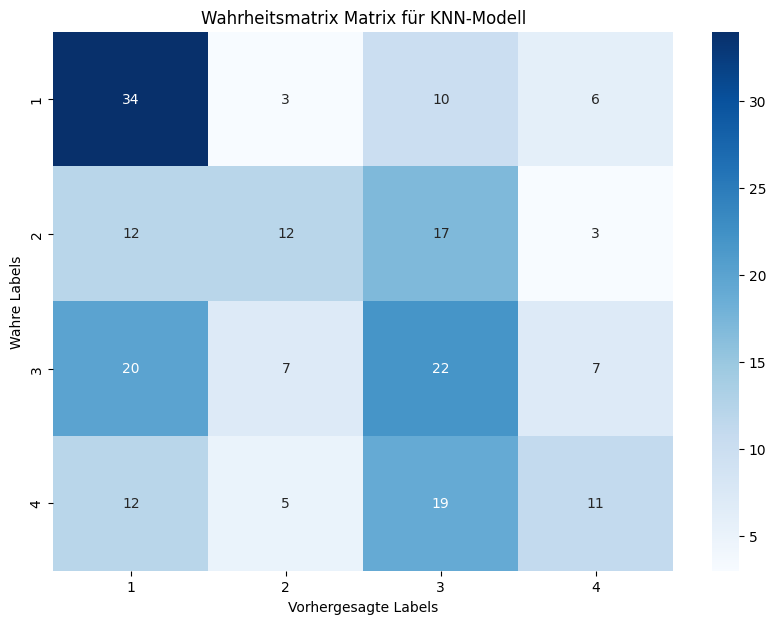

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Merkmale und Zielvariable definieren
X = telefonkunden[['tenure','age','income','address','employ','ed']] # Merkmale, die für die Vorhersage von 'custcat' relevant sind
Y = telefonkunden['custcat']

# Daten in Trainings- und Testset aufteilen 80/20 Split|Stratified --> gleiche Verteilung der Zielvariable
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# KNN-Modell erstellen und trainieren
knn = KNeighborsClassifier(n_neighbors=19)  # Anzahl der Nachbarn 
vorhersage_scikit = knn.fit(X_training, Y_training)

vorhersage_scikit = knn.predict(X_test)

# Genauigkeit der Vorhersage
print(accuracy_score(Y_test, vorhersage_scikit))

# Berechnung der Genauigkeit für verschiedene Werte von n_neighbors
scores = []
for k in range(1, 100):
	knn = KNeighborsClassifier(n_neighbors=k)
	knn.fit(X_training, Y_training)
	y_pred = knn.predict(X_test)
	scores.append(accuracy_score(Y_test, y_pred))

plt.figure(figsize=(10, 6)) 

plt.plot(np.arange(1, 100), scores, marker='o', linestyle='dashed')

plt.xlabel('Anzahl der Nachbarn')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit in Abhängigkeit der Anzahl der Nachbarn')
plt.show()

# Wahrheits Matrix
conf_matrix = confusion_matrix(Y_test, vorhersage_scikit)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahrheitsmatrix Matrix für KNN-Modell')
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'region']]
y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature-Skalierung
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# k-NN Modell erstellen und trainieren
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Vorhersagen machen
y_pred = knn.predict(X_test)

# Modellbewertung
print("k-NN Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("k-NN Genauigkeit:", accuracy_score(y_test, y_pred))


In [11]:
#################### Entscheidungsbaum (Decision Tree) ####################
# Ein Entscheidungsbaum ist ein Modell, das verwendet wird, um Entscheidungen zu treffen und Vorhersagen zu treffen.
# Er funktioniert, indem er die Daten in kleinere Teilmengen aufteilt, basierend auf bestimmten Merkmalen (Features).
# Jeder Knoten im Baum stellt eine Entscheidung dar, die auf einem bestimmten Merkmal basiert, und jeder Zweig stellt das Ergebnis dieser Entscheidung dar.
# Die Blätter des Baums repräsentieren die endgültigen Vorhersagen oder Entscheidungen.
# Entscheidungsbäume sind leicht zu interpretieren und können sowohl für Klassifikations- als auch für Regressionsaufgaben verwendet werden.

Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.41      0.40      0.40        53
           2       0.33      0.34      0.33        44
           3       0.36      0.38      0.37        56
           4       0.33      0.32      0.33        47

    accuracy                           0.36       200
   macro avg       0.36      0.36      0.36       200
weighted avg       0.36      0.36      0.36       200

Genauigkeit: 0.36


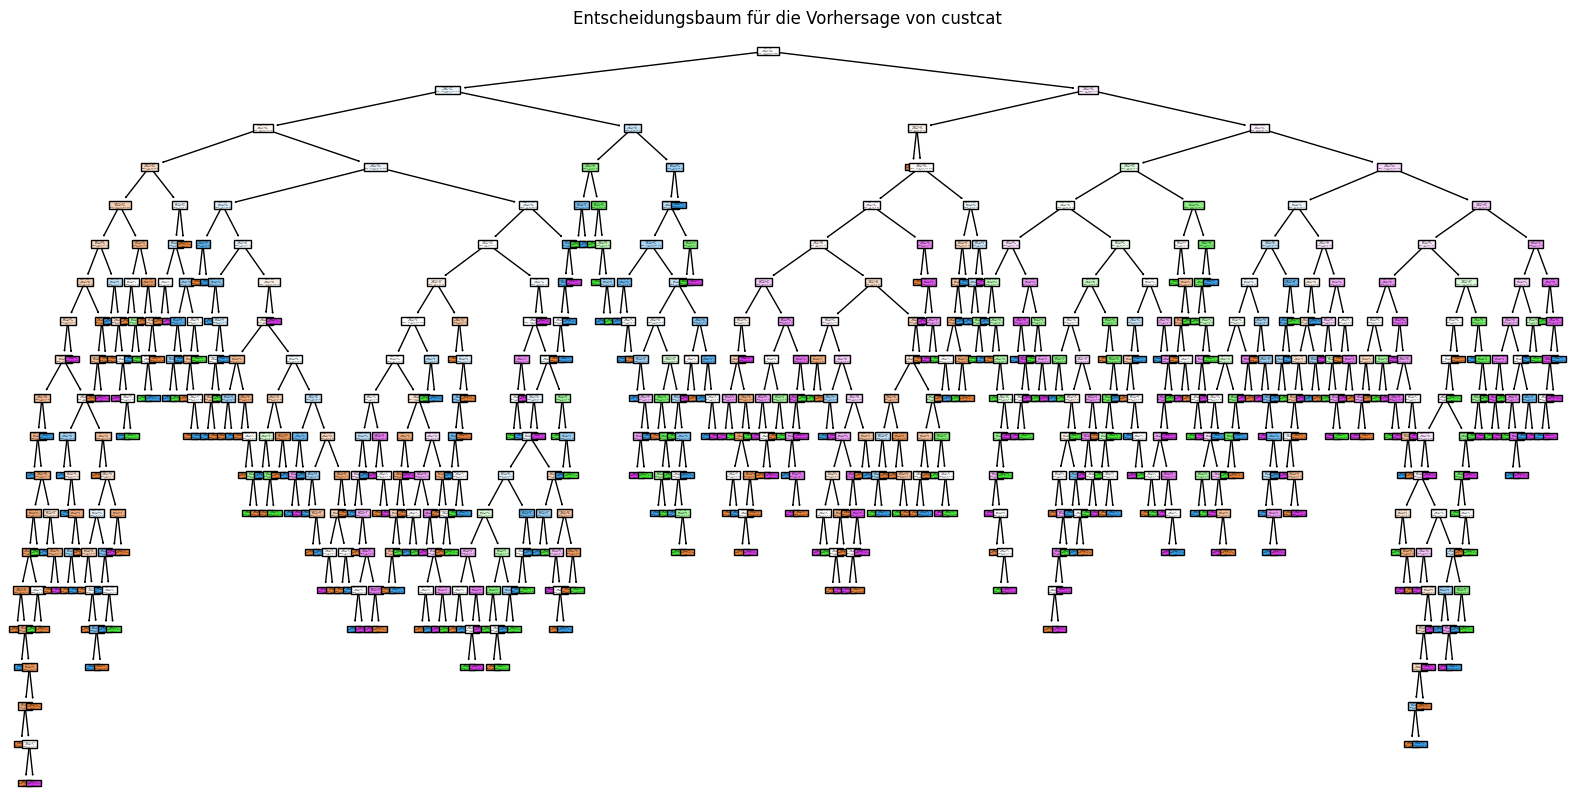

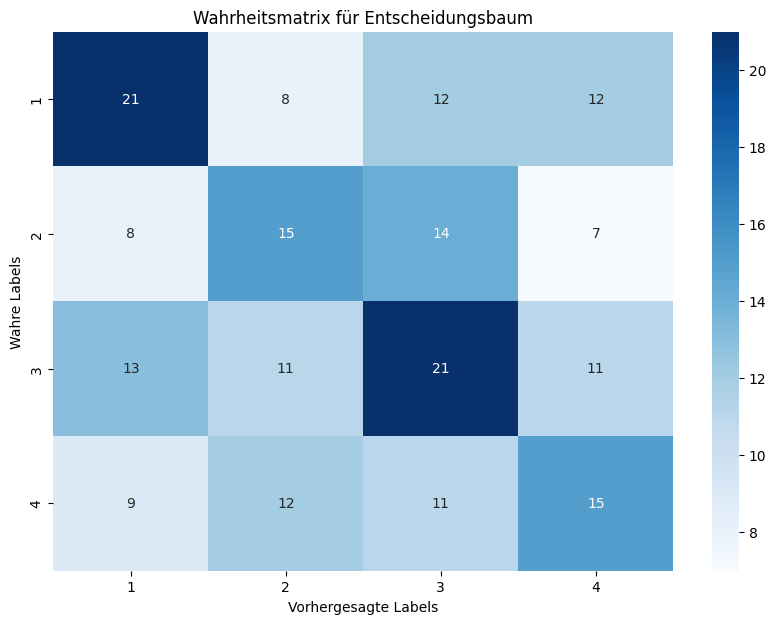

Feature Importance:
  Feature  Importance
2  income    0.276553
0  tenure    0.268701
1     age    0.231361
5  region    0.086536
3      ed    0.085130
4  gender    0.051719


In [12]:
# Entscheidungsbaum

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'region']] # Merkmale, die für die Vorhersage von 'custcat' relevant sind
Y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# Entscheidungsbaum-Modell erstellen und trainieren
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

# Vorhersagen machen
y_pred = tree.predict(X_test)

# Modellbewertung
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))
print("Genauigkeit:", accuracy_score(y_test, y_pred))

# Entscheidungsbaum visualisieren
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X.columns, class_names=[str(i) for i in tree.classes_], filled=True)
plt.title('Entscheidungsbaum für die Vorhersage von custcat')
plt.show()

# Wahrheitsmatrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=tree.classes_, yticklabels=tree.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Wahrheitsmatrix für Entscheidungsbaum')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': tree.feature_importances_})
print("Feature Importance:")
print(feature_importance.sort_values(by='Importance', ascending=False))


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'region']]
Y = telefonkunden['custcat']

# Datenaufteilung in Trainings- und Testdaten
X_training, X_test, Y_training, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# Hyperparameter-Tuning mit GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_training, Y_training)

# Beste Hyperparameter anzeigen
print("Beste Hyperparameter:", grid_search.best_params_)

# Entscheidungsbaum-Modell mit den besten Hyperparameter erstellen und trainieren
best_tree = grid_search.best_estimator_
best_tree.fit(X_training, Y_training)

# Vorhersagen machen
y_pred = best_tree.predict(X_test)

# Modellbewertung
# Convert one-hot encoded Y_test back to label format
Y_test_labels = Y_test.argmax(axis=1)
print("Klassifikationsbericht:")
print(classification_report(Y_test_labels, y_pred))
print("Genauigkeit:", accuracy_score(Y_test_labels, y_pred))

Beste Hyperparameter: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


ValueError: `axis` must be fewer than the number of dimensions (1)

In [ ]:
##################### Random Forest #####################
# Random Forest ist ein Ensemble-Lernalgorithmus, der aus mehreren Entscheidungsbäumen besteht.
# Jeder Baum im Wald wird auf einem zufälligen Unterdatensatz des Datensatzes trainiert.

In [57]:
# Random Forest Modell

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden.drop('custcat', axis=1)  # Alle Spalten außer 'custcat' als Features
y = telefonkunden['custcat']  # 'custcat' als Zielvariable

# Datenaufteilung in Trainings- und Testdaten
X_training, X_test, Y_training, Y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Random Forest Modell
rf = RandomForestClassifier(random_state=1)  # Random Forest Modell initialisieren
rf.fit(X_training, Y_training)  # Modell mit Trainingsdaten trainieren
y_pred_rf = rf.predict(X_test)  # Vorhersagen für Testdaten machen
print("Random Forest Klassifikationsbericht:")
print(classification_report(Y_test, y_pred_rf))  # Klassifikationsbericht ausgeben
print("Random Forest Genauigkeit:", accuracy_score(y_test, y_pred_rf))  # Genauigkeit ausgeben

# Gradient Boosting Modell
# Gradient Boosting ist ein leistungsstarkes Ensemble-Lernverfahren, das mehrere schwache Modelle (typischerweise Entscheidungsbäume) kombiniert, um ein starkes Vorhersagemodell zu erstellen, 
# indem es iterativ die Fehler der vorherigen Modelle korrigiert. Es minimiert eine Verlustfunktion durch Gradientenabstieg und verbessert so schrittweise die Gesamtvorhersagegenauigkeit.
gb = GradientBoostingClassifier(random_state=1)  # Gradient Boosting Modell initialisieren
gb.fit(X_training, Y_training)  # Modell mit Trainingsdaten trainieren
y_pred_gb = gb.predict(X_test)  # Vorhersagen für Testdaten machen
print("Gradient Boosting Klassifikationsbericht:")
print(classification_report(Y_test, y_pred_gb))  # Klassifikationsbericht ausgeben
print("Gradient Boosting Genauigkeit:", accuracy_score(Y_test, y_pred_gb))  # Genauigkeit ausgeben


Random Forest Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.50      0.53      0.51        53
           2       0.37      0.32      0.34        44
           3       0.37      0.43      0.40        56
           4       0.37      0.32      0.34        47

    accuracy                           0.41       200
   macro avg       0.40      0.40      0.40       200
weighted avg       0.40      0.41      0.40       200

Random Forest Genauigkeit: 0.405
Gradient Boosting Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.48      0.40      0.43        53
           2       0.37      0.36      0.37        44
           3       0.34      0.41      0.37        56
           4       0.40      0.38      0.39        47

    accuracy                           0.39       200
   macro avg       0.40      0.39      0.39       200
weighted avg       0.40      0.39      0.39       200

Gradient Boosting

In [ ]:
# Hyperparameter-Raster für Random Forest
# Ziel: Das optimale Set an Parametern für das Modell finden.
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Anzahl der Bäume im Wald
    'max_depth': [None, 10, 20, 30],  # Maximale Tiefe der Bäume
    'min_samples_split': [2, 5, 10],  # Minimale Anzahl von Proben, die erforderlich sind, um einen Knoten zu teilen
    'min_samples_leaf': [1, 2, 4]     # Minimale Anzahl von Proben, die in einem Blattknoten erforderlich sind
}

# GridSearchCV-Objekt für Random Forest erstellen
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid_rf, cv=5, scoring='accuracy')
# GridSearchCV: Automatisiert die Suche nach den besten Hyperparametern.
# param_grid_rf: Hyperparameter-Raster, über das iteriert wird.
# cv =5: Fünf-Fold-Cross-Validation zur Bewertung jedes Parameter-Sets.
# scoring='accuracy': Die Genauigkeit wird als Metrik verwendet, um die Leistung zu bewerten.

# GridSearchCV auf Trainingsdaten anwenden
grid_search_rf.fit(X_training, Y_training)

# Beste Hyperparameter anzeigen
print("Beste Hyperparameter für Random Forest:", grid_search_rf.best_params_)

# Bestes Modell aus GridSearchCV extrahieren
best_rf = grid_search_rf.best_estimator_

# Vorhersagen mit dem besten Modell machen
y_pred_best_rf = best_rf.predict(X_test)

# Klassifikationsbericht für das beste Modell anzeigen
print("Beste Random Forest Klassifikationsbericht:")
print(classification_report(Y_test, y_pred_best_rf))

# Genauigkeit des besten Modells anzeigen
print("Beste Random Forest Genauigkeit:", accuracy_score(Y_test, y_pred_best_rf))

Beste Hyperparameter für Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Beste Random Forest Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.49      0.55      0.52        53
           2       0.52      0.36      0.43        44
           3       0.39      0.46      0.43        56
           4       0.48      0.45      0.46        47

    accuracy                           0.46       200
   macro avg       0.47      0.46      0.46       200
weighted avg       0.47      0.46      0.46       200

Beste Random Forest Genauigkeit: 0.46


In [ ]:
##################### Neuronales Netz #####################
# Ein neuronales Netz ist ein Modell, das aus einer Reihe von miteinander verbundenen Neuronen besteht, die in Schichten organisiert sind.
# Jedes Neuron nimmt Eingaben, führt eine Berechnung durch und gibt eine Ausgabe weiter. Die Ausgaben der Neuronen in einer Schicht werden an die nächste Schicht weitergegeben.
# Neuronale Netze können verwendet werden, um komplexe nichtlineare Beziehungen in den Daten zu modellieren und Vorhersagen zu treffen.

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden[['tenure','age','income','ed', 'gender', 'region']]  # Auswahl der relevanten Features
y = telefonkunden['custcat']  # Zielvariable

# Zielvariable in kategorische Form umwandeln
y = to_categorical(y)  # One-Hot-Encoding der Zielvariable

# Datenaufteilung in Trainings- und Testdaten
X_training, X_test, Y_training, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Aufteilung der Daten in Trainings- und Testset

# Feature-Skalierung
scaler = StandardScaler()  # Initialisierung des StandardScalers
X_train = scaler.fit_transform(X_training)  # Anpassung und Transformation der Trainingsdaten
X_test = scaler.transform(X_test)  # Transformation der Testdaten

# Neuronales Netz erstellen
model = Sequential()  # Initialisierung des Modells
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Hinzufügen der ersten Schicht mit 64 Neuronen und ReLU-Aktivierung (Aktivierungsfunktion)
model.add(Dense(32, activation='relu'))  # Hinzufügen der zweiten Schicht mit 32 Neuronen und ReLU-Aktivierung
model.add(Dense(Y_training.shape[1], activation='softmax'))  # Hinzufügen der Ausgabeschicht mit Softmax-Aktivierung

# Modell kompilieren
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Kompilierung des Modells mit Verlustfunktion, Optimierer und Metrik

# Modell trainieren
model.fit(X_train, Y_training, epochs=50, validation_data=(X_test, Y_test), verbose=0)  # Training des Modells mit 50 Epochen und Validierungsdaten

# Vorhersagen machen
y_pred = model.predict(X_test)  # Vorhersagen für die Testdaten
y_pred_classes = y_pred.argmax(axis=1)  # Umwandlung der Vorhersagen in Klassen
y_test_classes = Y_test.argmax(axis=1)  # Umwandlung der Testdaten in Klassen

# Modellbewertung
print("Neuronales Netz Klassifikationsbericht:")  # Ausgabe des Klassifikationsberichts
print(classification_report(y_test_classes, y_pred_classes))  # Klassifikationsbericht anzeigen
print("Neuronales Netz Genauigkeit:", accuracy_score(y_test_classes, y_pred_classes))  # Genauigkeit des Modells anzeigen

c:\Users\adria\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Neuronales Netz Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.45      0.60      0.52        53
           2       0.33      0.32      0.33        44
           3       0.51      0.52      0.51        56
           4       0.40      0.26      0.31        47

    accuracy                           0.43       200
   macro avg       0.42      0.42      0.42       200
weighted avg       0.43      0.43      0.43       200

Neuronales Netz Genauigkeit: 0.435


In [ ]:
##################### NN Optimierungen #####################

# Batch Normalization: Die Batch-Normalisierungsschichten (BatchNormalization()) helfen, die Trainingsstabilität zu verbessern und die Konvergenz zu beschleunigen.
# Dropout: Die Dropout-Schichten (Dropout(0.5)) helfen, Überanpassung zu vermeiden, indem sie zufällig Neuronen während des Trainings deaktivieren.
# Early Stopping: Der Early Stopping Callback (EarlyStopping) beendet das Training, wenn sich die Validierungsleistung nicht mehr verbessert, um Überanpassung zu vermeiden.
# Erweiterte Optimierer: Der Adam-Optimierer (optimizer='adam') wird verwendet, um die Lernrate adaptiv anzupassen.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Datenaufteilung in Features (X) und Zielvariable (y)
X = telefonkunden.drop[['tenure','age','income','ed', 'gender', 'region']] # wenn alle Feautures verwendet werden ist die Genauigkeit identisch
y = telefonkunden['custcat']

# Zielvariable in kategorische Form umwandeln
y = to_categorical(y)

# Datenaufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature-Skalierung
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neuronales Netz erstellen
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())  # Batch-Normalisierung hinzufügen
model.add(Dropout(0.5))  # Dropout-Schicht hinzufügen
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())  # Batch-Normalisierung hinzufügen
model.add(Dropout(0.5))  # Dropout-Schicht hinzufügen
model.add(Dense(y_train.shape[1], activation='softmax'))

# Modell kompilieren
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modell trainieren
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# Vorhersagen machen
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

# Modellbewertung
print("Optimiertes Neuronales Netz Klassifikationsbericht:")
print(classification_report(y_test_classes, y_pred_classes))
print("Optimiertes Neuronales Netz Genauigkeit:", accuracy_score(y_test_classes, y_pred_classes))

c:\Users\adria\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Optimiertes Neuronales Netz Klassifikationsbericht:
              precision    recall  f1-score   support

           1       0.44      0.58      0.50        53
           2       0.57      0.27      0.37        44
           3       0.42      0.48      0.45        56
           4       0.52      0.49      0.51        47

    accuracy                           0.47       200
   macro avg       0.49      0.46      0.46       200
weighted avg       0.48      0.47      0.46       200

Optimiertes Neuronales Netz Genauigkeit: 0.465
